In [1]:
import numpy as np
from optiland import analysis, optic, optimization
from optiland.physical_apertures.rectangular import RectangularAperture
from optiland.analysis.irradiance import IncoherentIrradiance
from optiland.analysis.intensity import RadiantIntensity
from optiland.coordinate_system import CoordinateSystem
from optiland.materials import IdealMaterial, Material

from optiland.surfaces import Surface
from optiland.geometries import NurbsGeometry


import optiland.backend as be

In [22]:
import matplotlib.pyplot as plt
import optiland.backend as be

def plot_nurbs_control_points(surface, ax=None, figsize=(10, 8), color='r', label='Control Points'):
    """
    Plots the control points of a NURBS surface in 3D.
    
    Args:
        surface: The surface object containing the NURBS geometry.
        ax: Existing 3D axis to plot on. If None, a new figure is created.
        figsize: Tuple (width, height) for the figure size (only used if ax is None).
        color: Color of the control points and grid lines.
        label: Label for the legend.
    """
    geo = surface.geometry
    
    # Access control points and convert to numpy
    P = be.to_numpy(geo.P)

    # If no axis is provided, create a new figure and axis
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('X [mm]')
        ax.set_ylabel('Y [mm]')
        ax.set_zlabel('Z [mm]')
    
    # Set title if not already present
    if not ax.get_title():
        ax.set_title(f"NURBS Control Points (Surface {surface.name if hasattr(surface, 'name') else 'Unknown'})")

    # Plot control points
    ax.scatter(P[0].flatten(), P[1].flatten(), P[2].flatten(), c=color, marker='o', label=label)

    # Plot grid lines for structure (U direction)
    for i in range(P.shape[1]):
        ax.plot(P[0, i, :], P[1, i, :], P[2, i, :], color=color, linestyle='-', alpha=0.3)

    # Plot grid lines for structure (V direction)
    for j in range(P.shape[2]):
        ax.plot(P[0, :, j], P[1, :, j], P[2, :, j], color=color, linestyle='-', alpha=0.3)

    ax.legend()
    # Return the axis object to allow further plotting
    return ax

In [23]:
lens = optic.Optic(name="carta")

lens.set_field_type("angle")
lens.add_field(y=0)

lens.set_aperture(aperture_type="EPD", value=80)

lens.add_wavelength(value=0.587, is_primary=True)
val = 30
bar=RectangularAperture(
    y_max=val,
    y_min=-val,
    x_max=1,
    x_min=-1,
)
#lens.add_surface(index=0, radius=np.inf, thickness=np.inf)
lens.add_surface(index=0, z=-150, y=0, aperture=bar)
lens.add_surface(index=1, z=-100, aperture=bar)
#lens.add_surface(index=2, z=100, radius_y=200,radius_x=np.inf, material="mirror", rx=np.radians(-30), surface_type="toroidal", is_stop=True)


cs = CoordinateSystem(x=0, y=0, z=10, rx=np.radians(-40), ry=0, rz=0, reference_cs=None)
nurbs_geo = NurbsGeometry(
    coordinate_system=cs,
    nurbs_norm_x = 20,
    nurbs_norm_y = 140,
    n_points_u = 2,
    n_points_v = 20,
)
n_control_points_u = nurbs_geo.P_size_u
n_control_points_v = nurbs_geo.P_size_v
material_post = IdealMaterial(n=1)
new_surface = Surface(geometry=nurbs_geo, material_post=material_post, previous_surface=lens.surface_group.surfaces[1])
new_surface.interaction_model.is_reflective = True
lens.add_surface(index=2, new_surface=new_surface)

carta_aperture = RectangularAperture(
    y_max=600,
    y_min=-600,
    x_max=50,
    x_min=-50,
)
lens.add_surface(index=3, z=-100, y=-660, aperture=carta_aperture, is_stop=True)
#lens.surface_group.surfaces[1].aperture = aperture
#lens.surface_group.surfaces[2].aperture = carta_aperture
import copy
lens_original = copy.deepcopy(lens)


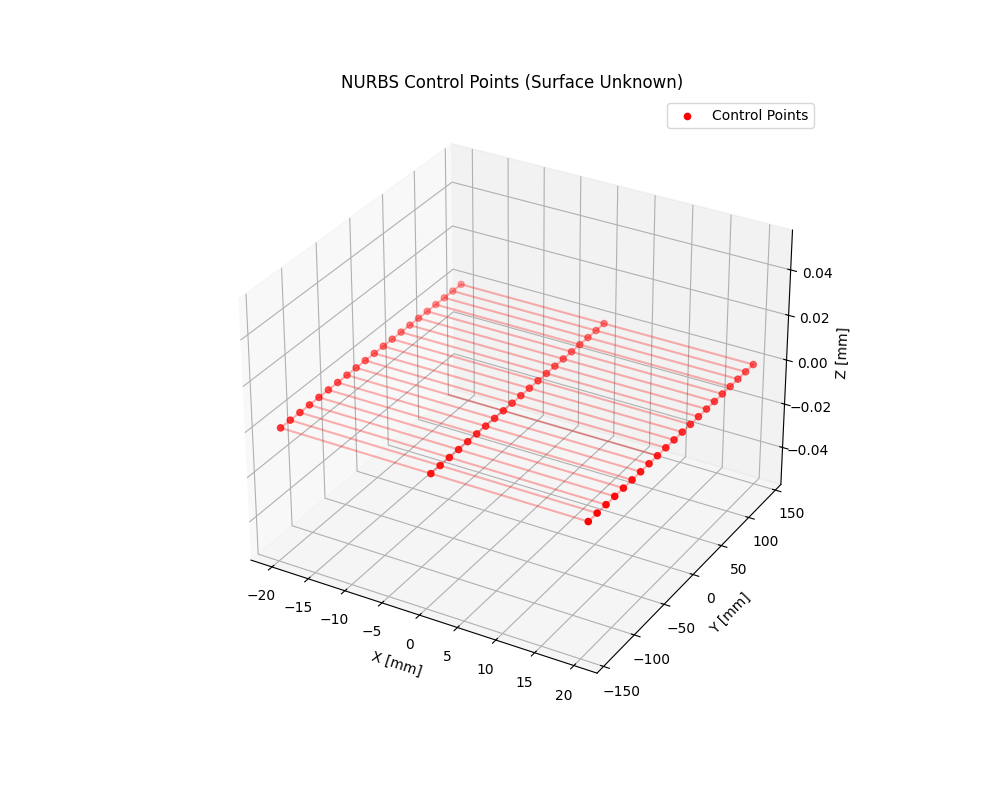

In [24]:
ax = plot_nurbs_control_points(lens.surface_group.surfaces[2])

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Z [mm]', ylabel='Y [mm]'>)

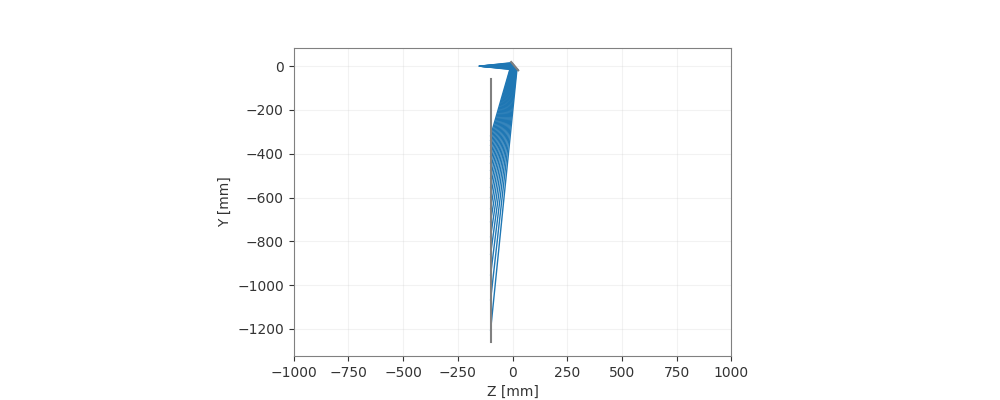

In [25]:
%matplotlib ipympl
lens.draw(num_rays=20, xlim=[-1000,1000])

In [26]:
problem = optimization.OptimizationProblem()

#for i in range(3):
#    for k in range(n_control_points_v):
#        problem.add_variable(lens, "nurbs_control_points_u", surface_number=2, coeff_index = [i,k], min_val=-120, max_val=200)

for k in range(n_control_points_v):
    for i in range(1,3):
        problem.add_variable(
            lens,
            "nurbs_control_points_u",
            surface_number=2,
            coeff_index=[i,k],
            min_val=-100,
            max_val=100,
        )

problem.add_variable(
    lens,
    "decenter",
    surface_number=2,
    axis="z",
    min_val = -100,
    max_val = 0,
)
problem.add_variable(
    lens,
    "decenter",
    surface_number=2,
    axis="y",
    min_val = -10,
    max_val = 10,
)

problem.add_variable(
    lens,
    "tilt",
    surface_number=2,
    axis="x",
    min_val = np.radians(-180),
    max_val = np.radians(180),
)
#for k in range(n_control_points_v):
#    problem.add_variable(lens, "nurbs_weights_u", surface_number=2, coeff_index = k, min_val=0, max_val=10)

n_rays = 40
for i in range(n_rays+1):
    input_data = {
        "optic": lens,           # Your lens system
        "surface_number": -1,     # Use -1 for the image plane
        "Hx": 0.0,                # Normalized Field X
        #"Hy": 60/80 -i*2/n_rays * 60/80,                # Normalized Field Y (e.g., full field)
        "Hy": 0.0,
        "Px": 0.0,                # Normalized Pupil X
        "Py": (1-i*2/n_rays)*60/80,                # Normalized Pupil Y (e.g., chief ray)
        "wavelength": 0.587       # Wavelength in microns
        }
    problem.add_operand(
        operand_type="real_y_intercept",
        target=-45-i*1280/n_rays,
        weight=1.0,
        input_data=input_data
    )
    #problem.add_operand(
    #    operand_type="real_x_intercept",
    #    target=0,
    #    weight=1.0,
    #    input_data=input_data
    #)

problem.info()


╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                 829029 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤══════════════════╤══════════╤══════════════╤══════════════╤══════════╤═══════════╤══════════╤════════════════╕
│    │ Operand Type     │   Target │ Min. Bound   │ Max. Bound   │   Weight │     Value │    Delta │   Contrib. [%] │
╞════╪══════════════════╪══════════╪══════════════╪══════════════╪══════════╪═══════════╪══════════╪════════════════╡
│  0 │ real y intercept │      -45 │              │              │        1 │  -370.052 │ -325.052 │          12.74 │
│  1 │ real y intercept │      -77 │              │              │        1 │  -378.883 │ -301.883 │          10.99 │
│  2 │ real y intercept │     -109 │              │              │        1 │  -388.002 │ -279.002 │           9.39 │
│  3 │ real y intercept │     -1

In [27]:
optimizer = optimization.OptimizerGeneric(problem)
#optimizer = optimization.BasinHopping(problem)
#optimizer = optimization.LeastSquares(problem)
history = []
def callback(xk):
    # xk is a numpy array of the current parameters
    history.append(xk)
    print(f"Iteration {len(history)}: x = {xk}")
#res = optimizer.optimize(callback=callback, tol=1e-15, method_choice="trf")
res = optimizer.optimize(callback=callback, tol=1e-22)
#optimizer = optimization.DifferentialEvolution(problem)
#res = optimizer.optimize(maxiter=5, workers=-1)
problem.info()

Optimization warning: Metric returned NaN at x=[-100.           0.        -100.           0.        -100.
    0.         -98.           0.         -84.           0.
  -70.           0.         -56.           0.         -42.
    0.         -28.           0.         -14.           0.
    0.           0.          14.           0.          28.
    0.          42.           0.          56.           0.
   70.           0.          84.           0.          98.
    0.         100.           0.         100.           0.
  100.           0.           0.           0.          -0.6981317]
Optimization warning: Metric returned NaN at x=[-1.00000000e+02  1.00000000e-08 -1.00000000e+02  0.00000000e+00
 -1.00000000e+02  0.00000000e+00 -9.80000000e+01  0.00000000e+00
 -8.40000000e+01  0.00000000e+00 -7.00000000e+01  0.00000000e+00
 -5.60000000e+01  0.00000000e+00 -4.20000000e+01  0.00000000e+00
 -2.80000000e+01  0.00000000e+00 -1.40000000e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.400000

/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:647: RuntimeWarning: divide by zero encountered in divide
  invj = adj / detJ
/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:647: RuntimeWarning: invalid value encountered in divide
  invj = adj / detJ
/home/mike/temp/lightbar-freeform-mirror/.venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:690: RuntimeWarning: divide by zero encountered in divide
  invj = adj / detJ
/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:690: RuntimeWarning: invalid value encountered in divide
  invj = adj / detJ
/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:647: RuntimeWarni

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                    nan │               nan │
╘════╧════════════════════════╧═══════════════════╛


/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:647: RuntimeWarning: divide by zero encountered in divide
  invj = adj / detJ
/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:647: RuntimeWarning: invalid value encountered in divide
  invj = adj / detJ
/home/mike/temp/lightbar-freeform-mirror/.venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:690: RuntimeWarning: divide by zero encountered in divide
  invj = adj / detJ
/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:690: RuntimeWarning: invalid value encountered in divide
  invj = adj / detJ
/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:647: RuntimeWarni

╒════╤══════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type     │   Target │ Min. Bound   │ Max. Bound   │   Weight │ Value   │ Delta   │   Contrib. [%] │
╞════╪══════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ real y intercept │      -45 │              │              │        1 │ +nan    │ +nan    │            nan │
│  1 │ real y intercept │      -77 │              │              │        1 │ +nan    │ +nan    │            nan │
│  2 │ real y intercept │     -109 │              │              │        1 │ +nan    │ +nan    │            nan │
│  3 │ real y intercept │     -141 │              │              │        1 │ +nan    │ +nan    │            nan │
│  4 │ real y intercept │     -173 │              │              │        1 │ +nan    │ +nan    │            nan │
│  5 │ real y intercept │     -205 │              │              │        1 │ +n

/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:647: RuntimeWarning: divide by zero encountered in divide
  invj = adj / detJ
/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:647: RuntimeWarning: invalid value encountered in divide
  invj = adj / detJ
/home/mike/temp/lightbar-freeform-mirror/.venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:690: RuntimeWarning: divide by zero encountered in divide
  invj = adj / detJ
/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:690: RuntimeWarning: invalid value encountered in divide
  invj = adj / detJ


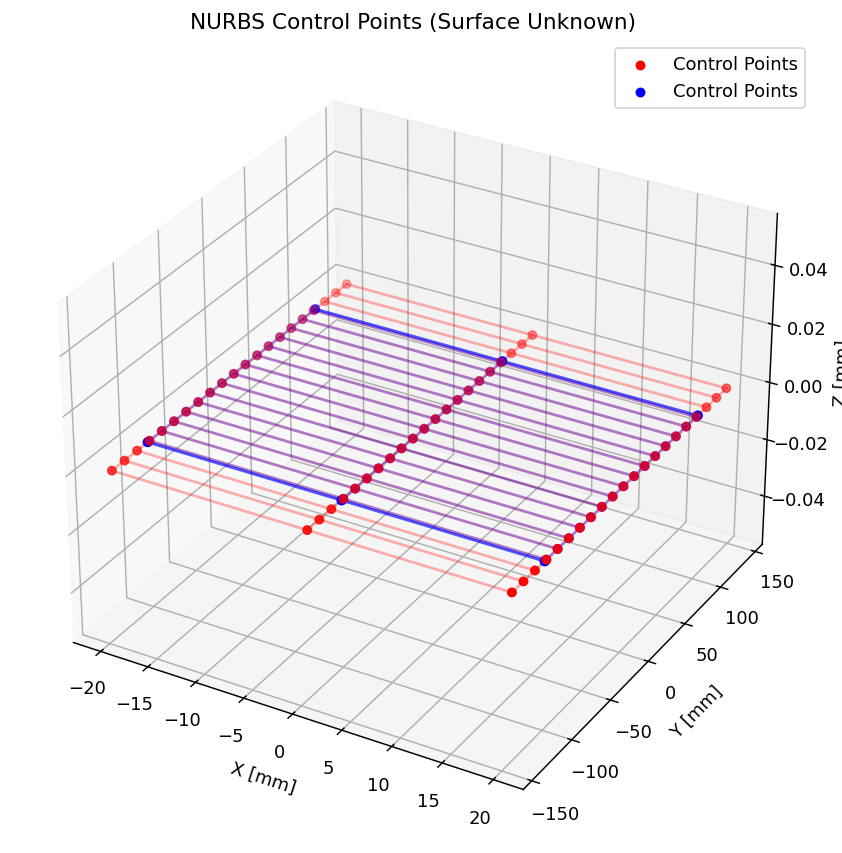

In [28]:
plot_nurbs_control_points(lens.surface_group.surfaces[2], color='b', ax=ax)
display(ax.figure)

/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:647: RuntimeWarning: divide by zero encountered in divide
  invj = adj / detJ
/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:647: RuntimeWarning: invalid value encountered in divide
  invj = adj / detJ
/home/mike/temp/lightbar-freeform-mirror/.venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:690: RuntimeWarning: divide by zero encountered in divide
  invj = adj / detJ
/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:690: RuntimeWarning: invalid value encountered in divide
  invj = adj / detJ
/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/visualization/system/rays.py:167: RuntimeWarning: Al

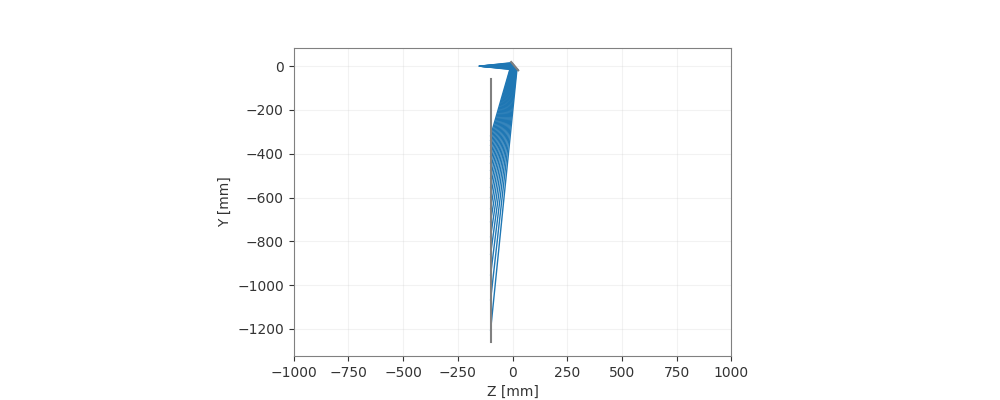

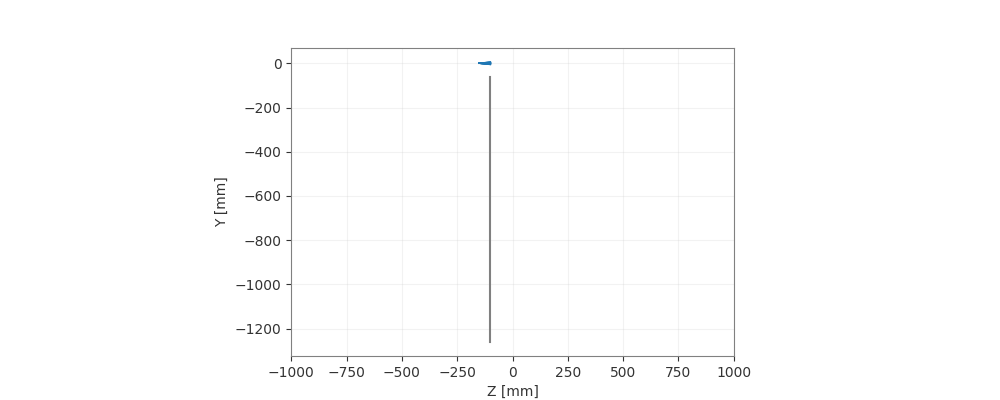

In [29]:
%matplotlib ipympl
import ipywidgets as widgets
fig1, ax1 = lens_original.draw(num_rays=20, xlim=[-1000,1000])
fig2, ax2 = lens.draw(num_rays=20, xlim=[-1000,1000])


# Wrap them in Output widgets
out1 = widgets.Output()
out2 = widgets.Output()

with out1:
    display(fig1)
with out2:
    display(fig2)

# Display side-by-side
widgets.HBox([out1, out2])

/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:647: RuntimeWarning: divide by zero encountered in divide
  invj = adj / detJ
/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:647: RuntimeWarning: invalid value encountered in divide
  invj = adj / detJ
/home/mike/temp/lightbar-freeform-mirror/.venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:690: RuntimeWarning: divide by zero encountered in divide
  invj = adj / detJ
/home/mike/temp/lightbar-freeform-mirror/optiland/optiland/geometries/nurbs/nurbs_geometry.py:690: RuntimeWarning: invalid value encountered in divide
  invj = adj / detJ


1
1280


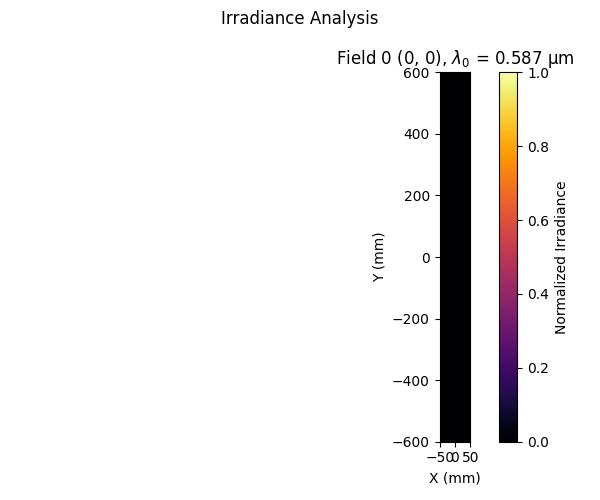

In [30]:
irradiance = IncoherentIrradiance(
    lens,
    #num_rays=1000_000,  # 1 million rays
    num_rays=1_000_00,
    detector_surface=-1,  # image surface
    distribution="line_y",
    res=[1,1280]
)
irradiance.view(normalize=True)
irr_data = irradiance.data
print(irradiance.npix_x)
print(irradiance.npix_y)

In [31]:
i = 0
for fblock in irr_data:
    for irr, *_ in fblock:
        irr_mean=be.mean(irr)
        irr_std=be.std(irr)
        irr_max=be.max(irr)
        irr_min=be.min(irr)

        if irr_mean > 0:
            rms_uniformity = irr_std / irr_mean
        else:
            rms_uniformity = 0

        if irr_mean > 0:
            irr_uniformity = (irr_max - irr_min) / irr_mean
        else:
            irr_uniformity = 0

print(irr_mean)
print(irr_uniformity)
print(rms_uniformity)
print(irr_max)
print(irr_min)

0.0
0
0
0.0
0.0


In [32]:
from optiland.fileio import save_optiland_file
save_optiland_file(lens, "optimization1.json")